In [ ]:
from google.colab import files

uploaded = files.upload()

Saving vaccination_tweets.csv to vaccination_tweets (1).csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import itertools
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df = pd.read_csv('vaccination_tweets.csv')

In [ ]:
df.shape

(4047, 16)

In [ ]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [ ]:
df.drop(['id','user_name'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047 entries, 0 to 4046
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_location     3206 non-null   object
 1   user_description  3788 non-null   object
 2   user_created      4047 non-null   object
 3   user_followers    4047 non-null   int64 
 4   user_friends      4047 non-null   int64 
 5   user_favourites   4047 non-null   int64 
 6   user_verified     4047 non-null   bool  
 7   date              4047 non-null   object
 8   text              4047 non-null   object
 9   hashtags          3016 non-null   object
 10  source            4046 non-null   object
 11  retweets          4047 non-null   int64 
 12  favorites         4047 non-null   int64 
 13  is_retweet        4047 non-null   bool  
dtypes: bool(2), int64(5), object(7)
memory usage: 387.4+ KB


In [ ]:
df['user_created']=pd.to_datetime(df['user_created'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
df.describe()

In [ ]:
missingvalue = df.isnull().sum()
missingvalue[missingvalue!=0]

user_location        841
user_description     259
hashtags            1031
source                 1
dtype: int64

In [ ]:
df['user_location'].nunique()

1321

In [ ]:
df['user_description'] = df['user_description'].fillna('No Description')

In [ ]:
df['hashtags'] = df['hashtags'].fillna('')

In [ ]:
df['source'] = df['source'].fillna('No Source')

In [ ]:
missingvalue = df.isnull().sum()
missingvalue[missingvalue!=0]

user_location    841
dtype: int64

In [ ]:
df.columns

Index(['user_location', 'user_description', 'user_created', 'user_followers',
       'user_friends', 'user_favourites', 'user_verified', 'date', 'text',
       'hashtags', 'source', 'retweets', 'favorites', 'is_retweet'],
      dtype='object')

In [ ]:
cont_features = ['user_followers','user_friends', 'user_favourites', 'retweets', 'favorites','date']

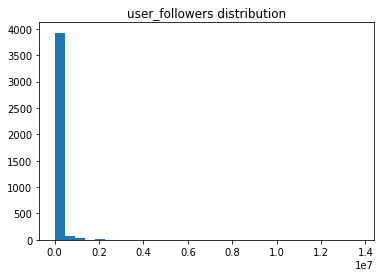

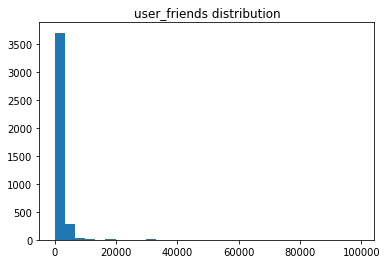

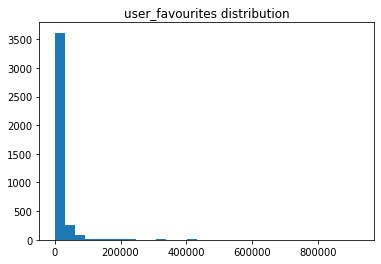

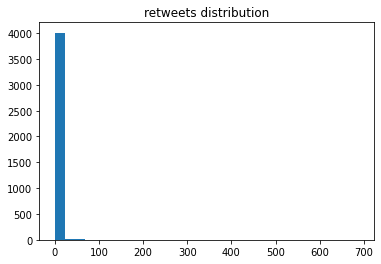

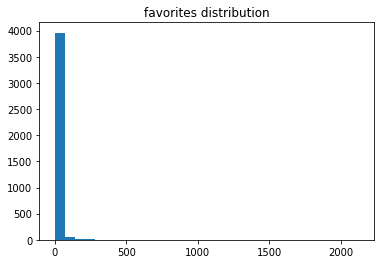

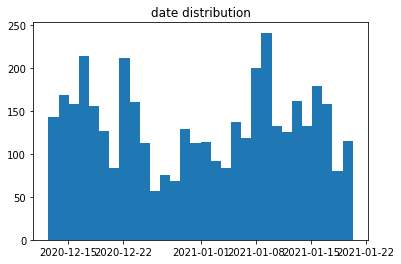

In [ ]:
for feature in cont_features:
    plt.figure()
    plt.hist(df[feature], label=feature, bins= 30)
    plt.title('{} distribution'.format(feature))
    plt.show()


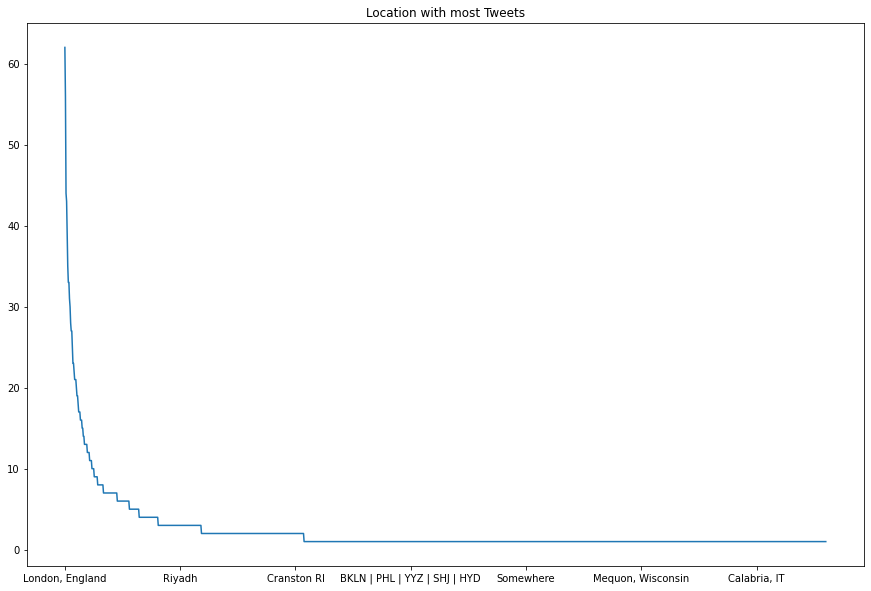

In [ ]:
plt.figure(figsize=(15,10))
locationWise = df.user_location.value_counts().plot(title='Location with most Tweets')

## NLP Preprocessing

In [ ]:
df["up_text"] = df.text.str.lower()

In [ ]:
#Remove twitter handlers
df.up_text = df.up_text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df.up_text = df.up_text.apply(lambda x:re.sub(r'\B#\S+','',x))

# Remove URLS
df.up_text = df.up_text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
df.up_text = df.up_text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

df.sort_values("date", inplace=True)
df.head()

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,up_text
44,Egypt,Egypt's Only Daily Independent Newspaper in En...,2009-04-26 07:56:24,278080,116,765,True,2020-12-12 11:55:28,#FDA authorizes #PfizerBioNTech #coronavirus v...,"['FDA', 'PfizerBioNTech', 'coronavirus']",Twitter Web App,1,1,False,authorizes vaccine for emergency use
43,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,Trump announces #vaccine rollout 'in less than...,['vaccine'],Twitter Web App,0,2,False,trump announces rollout in less than 24 hours ...
42,NaN,I believe in the goodness of humanity.,2020-05-20 10:57:00,14,162,1341,False,2020-12-12 12:12:35,#CovidVaccine #Pfizer-BioNTech COVID-19 #Pfize...,"['CovidVaccine', 'Pfizer', 'PfizerBioNTech', '...",Twitter for iPhone,0,1,False,covid 19
41,USA🇺🇸,"RN, health educator, writer, researcher, wife,...",2014-01-31 01:25:24,2035,1672,6734,False,2020-12-12 12:16:14,FACT SHEET FOR RECIPIENTS AND CAREGIVERS\n\n#P...,"['PfizerBioNTech', 'CovidVaccine']",Twitter Web App,0,0,False,fact sheet for recipients and caregivers
40,"Wales, United Kingdom",No lie to another is respectful; no lie to you...,2016-08-03 20:11:00,761,504,33675,False,2020-12-12 12:16:27,@mirekR9 @sputnikvaccine @AstraZeneca it's the...,['PfizerBioNTech'],Twitter Web App,0,0,False,itthe only one which doesnhave any side effect...


In [ ]:
df.hashtags=df.hashtags.str.replace('[','')
df.hashtags=df.hashtags.str.replace(']','')
df.hashtags=df.hashtags.str.replace("'",'')

In [ ]:
hashtags_list = list(itertools.chain(*df.hashtags.str.split(',')))

In [ ]:
hash = ""
for _ in hashtags_list:
    hash += _+" "

In [ ]:
def plot_cloud(wordcloud, title):
    plt.figure(figsize=(20, 15))
    plt.title(title)
    plt.imshow(wordcloud) 
    plt.axis("off");

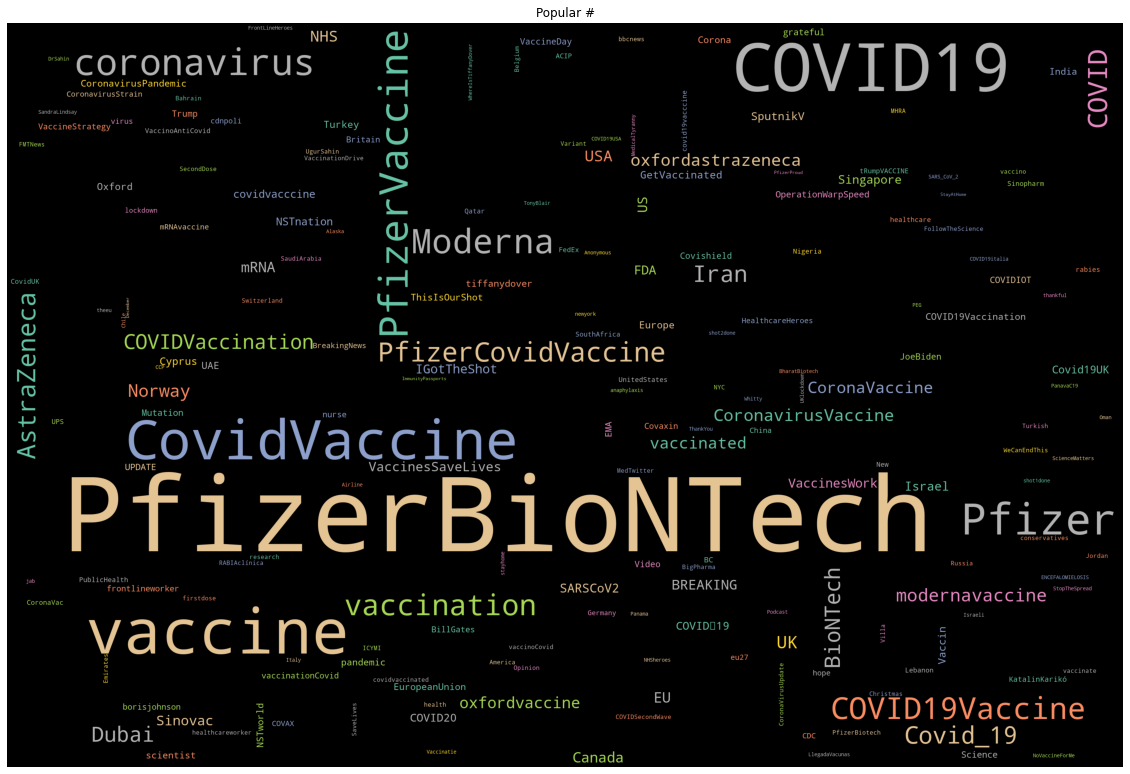

In [ ]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(hash)
plot_cloud(wordcloud, 'Popular #')

In [ ]:
at = []
for text in df.text.unique():
    text = re.findall('@[^\s]+',text )
    for _ in text:
        at.append(_)

ats = ""
for _ in at:
    ats+=_+" "

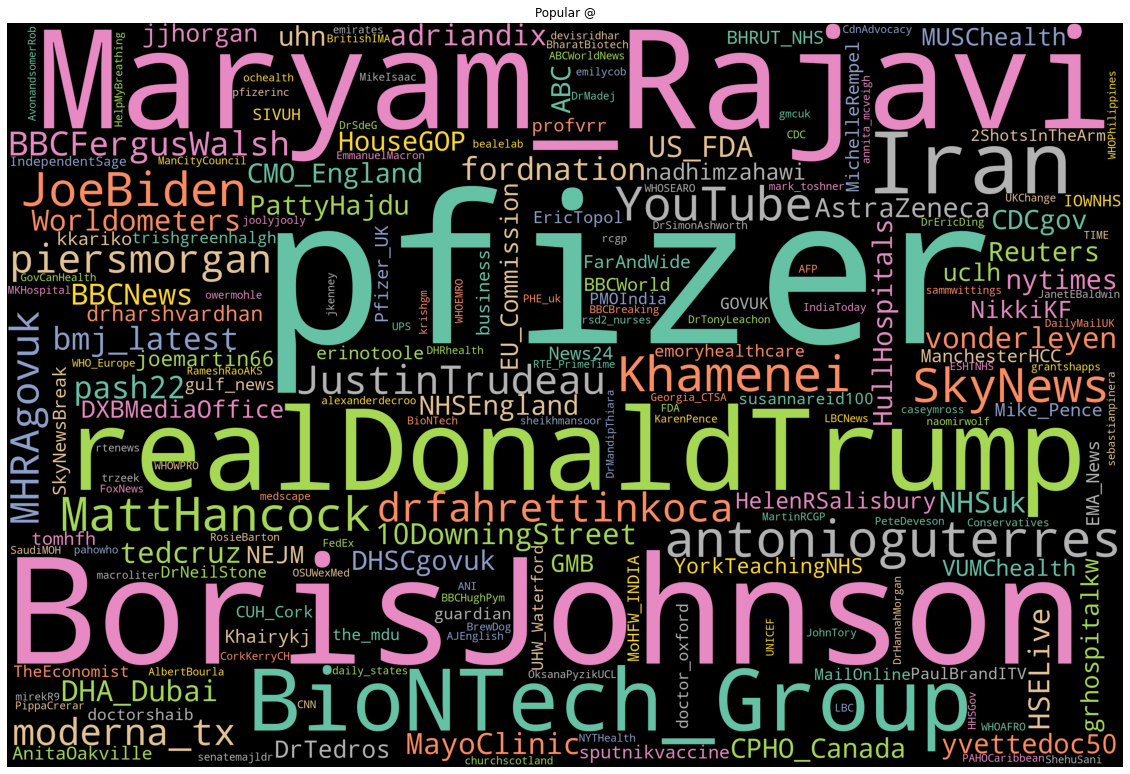

In [ ]:
# Generate word cloud and Plot
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(ats)
plot_cloud(wordcloud, 'Popular @')

## Sentiment Analysis

In [ ]:
sid = SIA()
df['sia'] = df['up_text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
df['positive sentiments'] = df['sia'].apply(lambda x: x['pos']+1*(10**-6)) 
df['neutral sentiments'] = df['sia'].apply(lambda x: x['neu']+1*(10**-6))
df['negative sentiments'] = df['sia'].apply(lambda x: x['neg']+1*(10**-6))

df.drop(columns=['sia'],inplace=True)

In [ ]:
df.head()

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,up_text,positive sentiments,neutral sentiments,negative sentiments
44,Egypt,Egypt's Only Daily Independent Newspaper in En...,2009-04-26 07:56:24,278080,116,765,True,2020-12-12 11:55:28,#FDA authorizes #PfizerBioNTech #coronavirus v...,"[FDA, PfizerBioNTech, coronavirus]",Twitter Web App,1,1,False,authorizes vaccine for emergency use,0.000001,0.606001,0.394001
43,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 11:59:10,Trump announces #vaccine rollout 'in less than...,[vaccine],Twitter Web App,0,2,False,trump announces rollout in less than 24 hours ...,0.000001,1.000001,0.000001
42,NaN,I believe in the goodness of humanity.,2020-05-20 10:57:00,14,162,1341,False,2020-12-12 12:12:35,#CovidVaccine #Pfizer-BioNTech COVID-19 #Pfize...,"[CovidVaccine, Pfizer, PfizerBioNTech, COVI...",Twitter for iPhone,0,1,False,covid 19,0.000001,1.000001,0.000001
41,USA🇺🇸,"RN, health educator, writer, researcher, wife,...",2014-01-31 01:25:24,2035,1672,6734,False,2020-12-12 12:16:14,FACT SHEET FOR RECIPIENTS AND CAREGIVERS\n\n#P...,"[PfizerBioNTech, CovidVaccine]",Twitter Web App,0,0,False,fact sheet for recipients and caregivers,0.000001,1.000001,0.000001
40,"Wales, United Kingdom",No lie to another is respectful; no lie to you...,2016-08-03 20:11:00,761,504,33675,False,2020-12-12 12:16:27,@mirekR9 @sputnikvaccine @AstraZeneca it's the...,[PfizerBioNTech],Twitter Web App,0,0,False,itthe only one which doesnhave any side effect...,0.000001,1.000001,0.000001


In [ ]:
print(df[df['negative sentiments']>0.5]['text'].sample(5))

2015    @rhysblakely @adamboultonSKY #PfizerBioNTech t...
1079    @OANN Awful. God have mercy on those being man...
539     #BREAKING #PfizerBioNTech #COVID19 #vaccine pr...
536     BREAKING #PfizerBioNTech #COVID19 #vaccine pro...
369     @CDCgov You can stick your poison vaccine up y...
Name: text, dtype: object


In [ ]:
df['total sentiments'] = df['negative sentiments'] + df['positive sentiments'] + df['neutral sentiments']

In [ ]:
df['total sentiments'].unique()

In [ ]:
df[df['total sentiments']==3.000000e-06]['up_text'].unique()

In [ ]:
def get_sentiment(df):
  sent = [df['negative sentiments'],df['positive sentiments'],df['neutral sentiments']]
  max = np.argmax(sent)
  if max ==0:
    return 'Neg'
  elif max ==1:
    return 'Pos'
  else:
    return 'Neut'

In [ ]:
df['sentiments'] =df.apply(get_sentiment,axis=1)

In [ ]:
sid = SIA()
df['sia'] = df['hashtags'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
df['positive sentiments #'] = df['sia'].apply(lambda x: x['pos']+1*(10**-6)) 
df['neutral sentiments #'] = df['sia'].apply(lambda x: x['neu']+1*(10**-6))
df['negative sentiments #'] = df['sia'].apply(lambda x: x['neg']+1*(10**-6))

df.drop(columns=['sia'],inplace=True)

In [ ]:
def get_sentiment_hashtags(df):
  sent = [df['negative sentiments #'],df['positive sentiments #'],df['neutral sentiments #']]
  max = np.argmax(sent)
  if max ==0:
    return 'Neg'
  elif max ==1:
    return 'Pos'
  else:
    return 'Neut'

In [ ]:
df['sentiments #'] =df.apply(get_sentiment_hashtags,axis=1)
df['same sentiment'] = (df['sentiments'] == df['sentiments #'])
len(df[(df['same sentiment']==False) & (df['up_text']!='')])

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
df.to_csv('/content/gdrive/MyDrive/tweet_db_up.csv')

In [ ]:
df